<a href="https://colab.research.google.com/github/NewCodeLearner/LLM-finetunning/blob/main/2_Fine_tuning_DeepSeek_R1(Reasoning_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About DeepSeek R1

**DeepSeek-R1-Zero**
DeepSeek-R1-Zero is the first open-source model trained solely with large-scale reinforcement learning (RL) instead of supervised fine-tuning (SFT) as an initial step. This approach enables the model to independently explore chain-of-thought (CoT) reasoning, solve complex problems, and iteratively refine its outputs. However, it comes with challenges such as repetitive reasoning steps, poor readability, and language mixing that can impact its clarity and usability.

**DeepSeek-R1**
DeepSeek-R1 was introduced to overcome the limitations of DeepSeek-R1-Zero by incorporating cold-start data before reinforcement learning, providing a strong foundation for reasoning and non-reasoning tasks.

This multi-stage training enables the model to achieve state-of-the-art performance, comparable to OpenAI-o1, across math, code, and reasoning benchmarks while improving its output's readability and coherence.




# 1. Setting up

For this project, we are using Google Colab as our Cloud IDE because it provides free access to GPUs, To get started, launch a new Colab notebook and add your Hugging Face token and Weights & Biases token as secrets.  

After setting up the secrets, install the unsloth Python package. Unsloth is an open-source framework designed to make fine-tuning large language models (LLMs) 2X faster and more memory-efficient.

In [1]:
%%capture
!pip install unsloth
!pip install --force-reinstall --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

Log in to the Hugging Face CLI using the Hugging Face API that we securely extracted from Colab Secrets.

In [2]:
from huggingface_hub import login
from google.colab import userdata


hf_token = userdata.get('HF_TOKEN')
login(hf_token)

Log in to Weights & Biases (wandb) using your API key and create a new project to track the experiments and fine-tuning progress.

In [3]:
import wandb

wb_token = userdata.get('WANDB_KEY')

wandb.login(key=wb_token)
run = wandb.init(
    project='Fine-tune-DeepSeek-R1-Distill-Llama-8B on Medical COT Dataset',
    job_type="training",
    anonymous="allow"
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: girish-barhate (girish-barhate-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


# 2. Loading the model and tokenizer

For this project, we are loading the Unsloth version of DeepSeek-R1-Distill-Llama-8B.  Additionally, we will load the model in 4-bit quantization to optimize memory usage and performance.

In [4]:
from unsloth import FastLanguageModel

max_seq_length = 2048
dtype = None
load_in_4bit =True

model,tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/DeepSeek-R1-Distill-Llama-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    token = hf_token
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.1.8: Fast Llama patching. Transformers: 4.47.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.9k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

# 3. Model inference before fine-tuning

To create a prompt style for the model, we will define a system prompt and include placeholders for the question and response generation. The prompt will guide the model to think step-by-step and provide a logical, accurate response.

In [5]:
prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.
Please answer the following medical question.

### Question:
{}

### Response:
<think>{}"""

we will provide a medical question to the prompt_style, convert it into tokens, and then pass the tokens to the model for response generation.

In [6]:
question = "A 61-year-old woman with a long history of involuntary urine loss during activities like coughing or sneezing but no leakage at night undergoes a gynecological exam and Q-tip test. Based on these findings, what would cystometry most likely reveal about her residual volume and detrusor contractions?"


FastLanguageModel.for_inference(model)
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")

outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=1200,
    use_cache=True,
)
response = tokenizer.batch_decode(outputs)
print(response[0].split("### Response:")[1])


<think>
Alright, so I'm trying to figure out what the cystometry would show for this 61-year-old woman. Let me break this down step by step.

First, the patient has a history of involuntary urine loss when she coughs or sneezes. That makes me think of stress urinary incontinence. I remember that stress incontinence is usually due to uretal sphincter weakness, especially when it happens during activities that increase intra-abdominal pressure, like coughing.

She's been diagnosed with this issue for a long time, so it's likely a long-standing problem. The fact that she doesn't leak at night suggests that it's not a predominant issue of nocturnal enuresis, which is more common in younger people or due to other conditions like diabetes or neurological issues.

She underwent a gynecological exam and a Q-tip test. I'm a bit fuzzy on the Q-tip test specifics, but I think it's used to assess urethral function. The Q-tip is a small catheter with a balloon that's filled with water and then rem

Even without fine-tuning, our model successfully generated a chain of thought and provided reasoning before delivering the final answer. The reasoning process is encapsulated within the <think></think> tags.

So, why do we still need fine-tuning? The reasoning process, while detailed, was long-winded and not concise. Additionally, the final answer was presented in a bullet-point format, which deviates from the structure and style of the dataset that we want to fine-tune on.

# 4. Loading and processing the dataset

We will slightly change the prompt style for processing the dataset by adding the third placeholder for the complex chain of thought column.

In [7]:
train_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.
Please answer the following medical question.

### Question:
{}

### Response:
<think>
{}
</think>
{}"""

Write the Python function that will create a "text" column in the dataset, which consists of the train prompt style. Fill the placeholders with questions, chains of text, and answers.

In [8]:
EOS_TOKEN = tokenizer.eos_token  # Must add EOS_TOKEN

def formatting_prompts_func(examples):
    inputs = examples["Question"]
    cots = examples["Complex_CoT"]
    outputs = examples["Response"]
    texts = []
    for input, cot, output in zip(inputs, cots, outputs):
        text = train_prompt_style.format(input, cot, output) + EOS_TOKEN
        texts.append(text)
    return {
        "text": texts,
    }

We will load the first 500 samples from the FreedomIntelligence/medical-o1-reasoning-SFT dataset, which is available on the Hugging Face hub. After that, we will map the text column using the formatting_prompts_func function.

In [9]:
from datasets import load_dataset
dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT","en", split = "train[0:500]",trust_remote_code=True)
dataset = dataset.map(formatting_prompts_func, batched = True,)
dataset["text"][0]

README.md:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

medical_o1_sft.json:   0%|          | 0.00/74.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25371 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

"Below is an instruction that describes a task, paired with an input that provides further context. \nWrite a response that appropriately completes the request. \nBefore answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.\n\n### Instruction:\nYou are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning. \nPlease answer the following medical question. \n\n### Question:\nA 61-year-old woman with a long history of involuntary urine loss during activities like coughing or sneezing but no leakage at night undergoes a gynecological exam and Q-tip test. Based on these findings, what would cystometry most likely reveal about her residual volume and detrusor contractions?\n\n### Response:\n<think>\nOkay, let's think about this step by step. There's a 61-year-old woman here who's been dealing with involuntary urine leakages whenever she's doing something that ups her ab

As we can see, the text column has a system prompt, instructions, chain of thought, and the answer.

# 5. Setting up the model

Using the target modules, we will set up the model by adding the low-rank adopter to the model

In [10]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",  # True or "unsloth" for very long context
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

Unsloth 2025.1.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Next, we will set up the training arguments and the trainer by providing the model, tokenizers, dataset, and other important training parameters that will optimize our fine-tuning process.

In [12]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    dataset_text_field="text",
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        # Use num_train_epochs = 1, warmup_ratio for full training runs!
        warmup_steps=5,
        max_steps=60,
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=10,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
    ),
)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

# 6. Model training

Run the following command to start training.

In [13]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 500 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss
10,1.918800


Step,Training Loss
10,1.918800
20,1.461500
30,1.402300
40,1.308800
50,1.344300
60,1.314000


You can view the fill model evaluation report on the Weights and bais dash board by loging into theo the website and viewin the project.

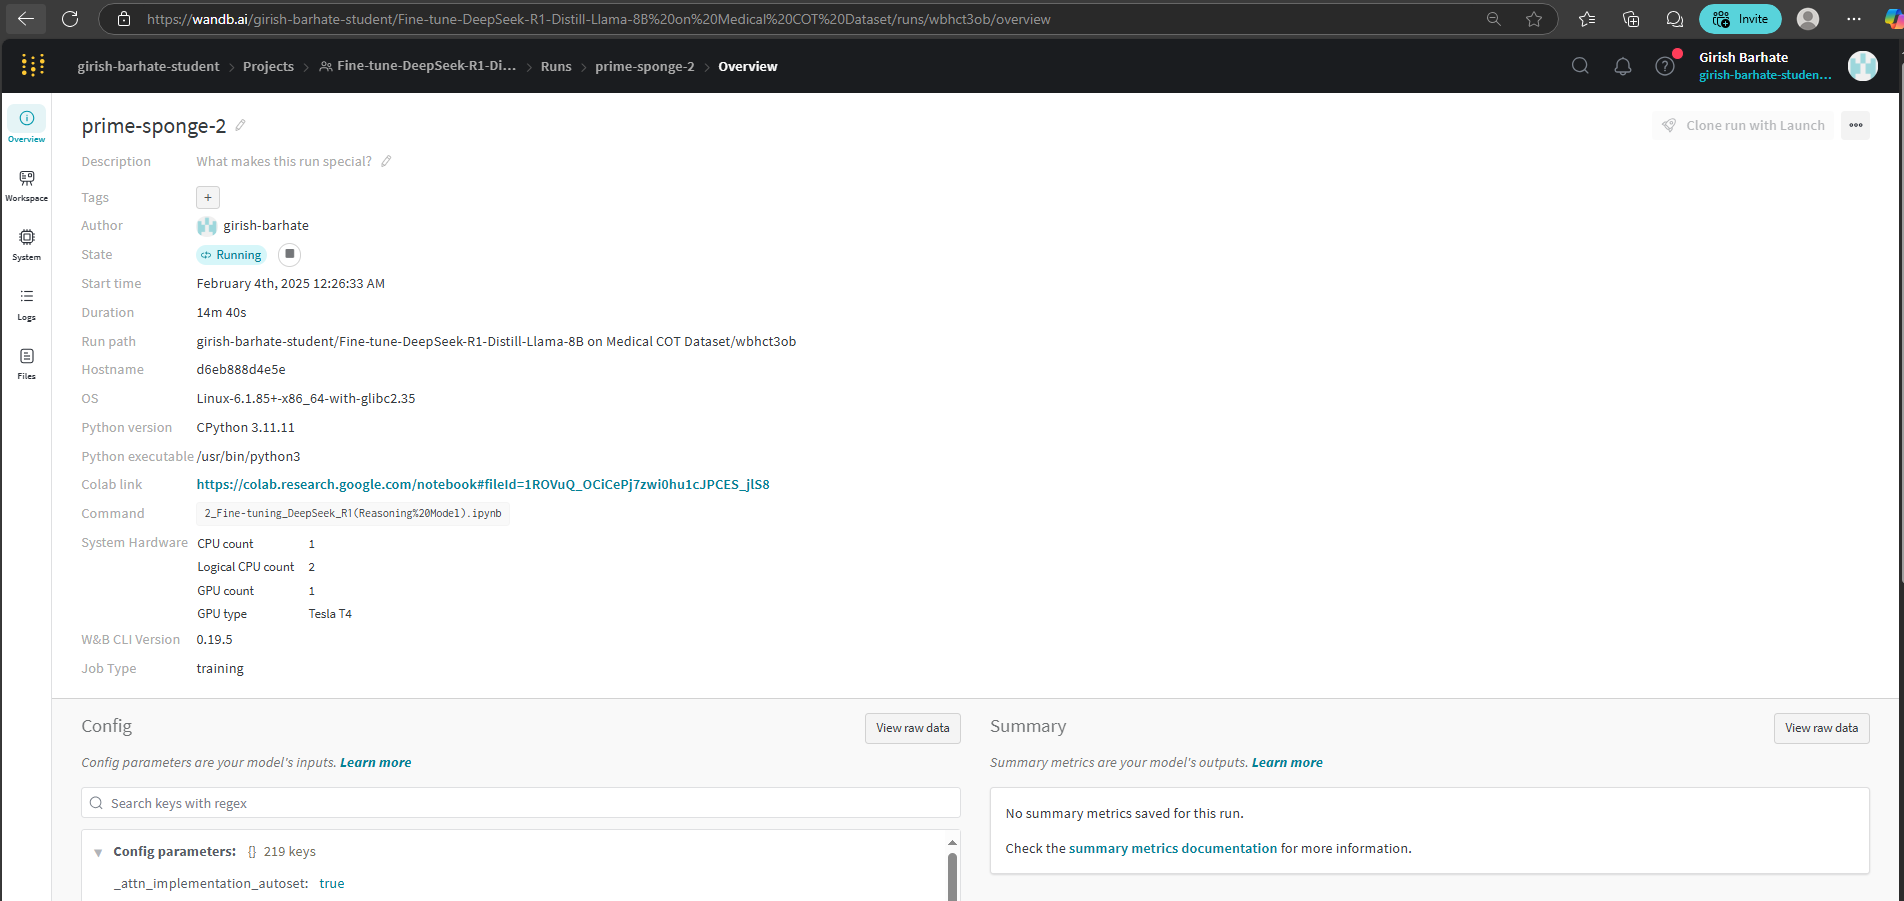

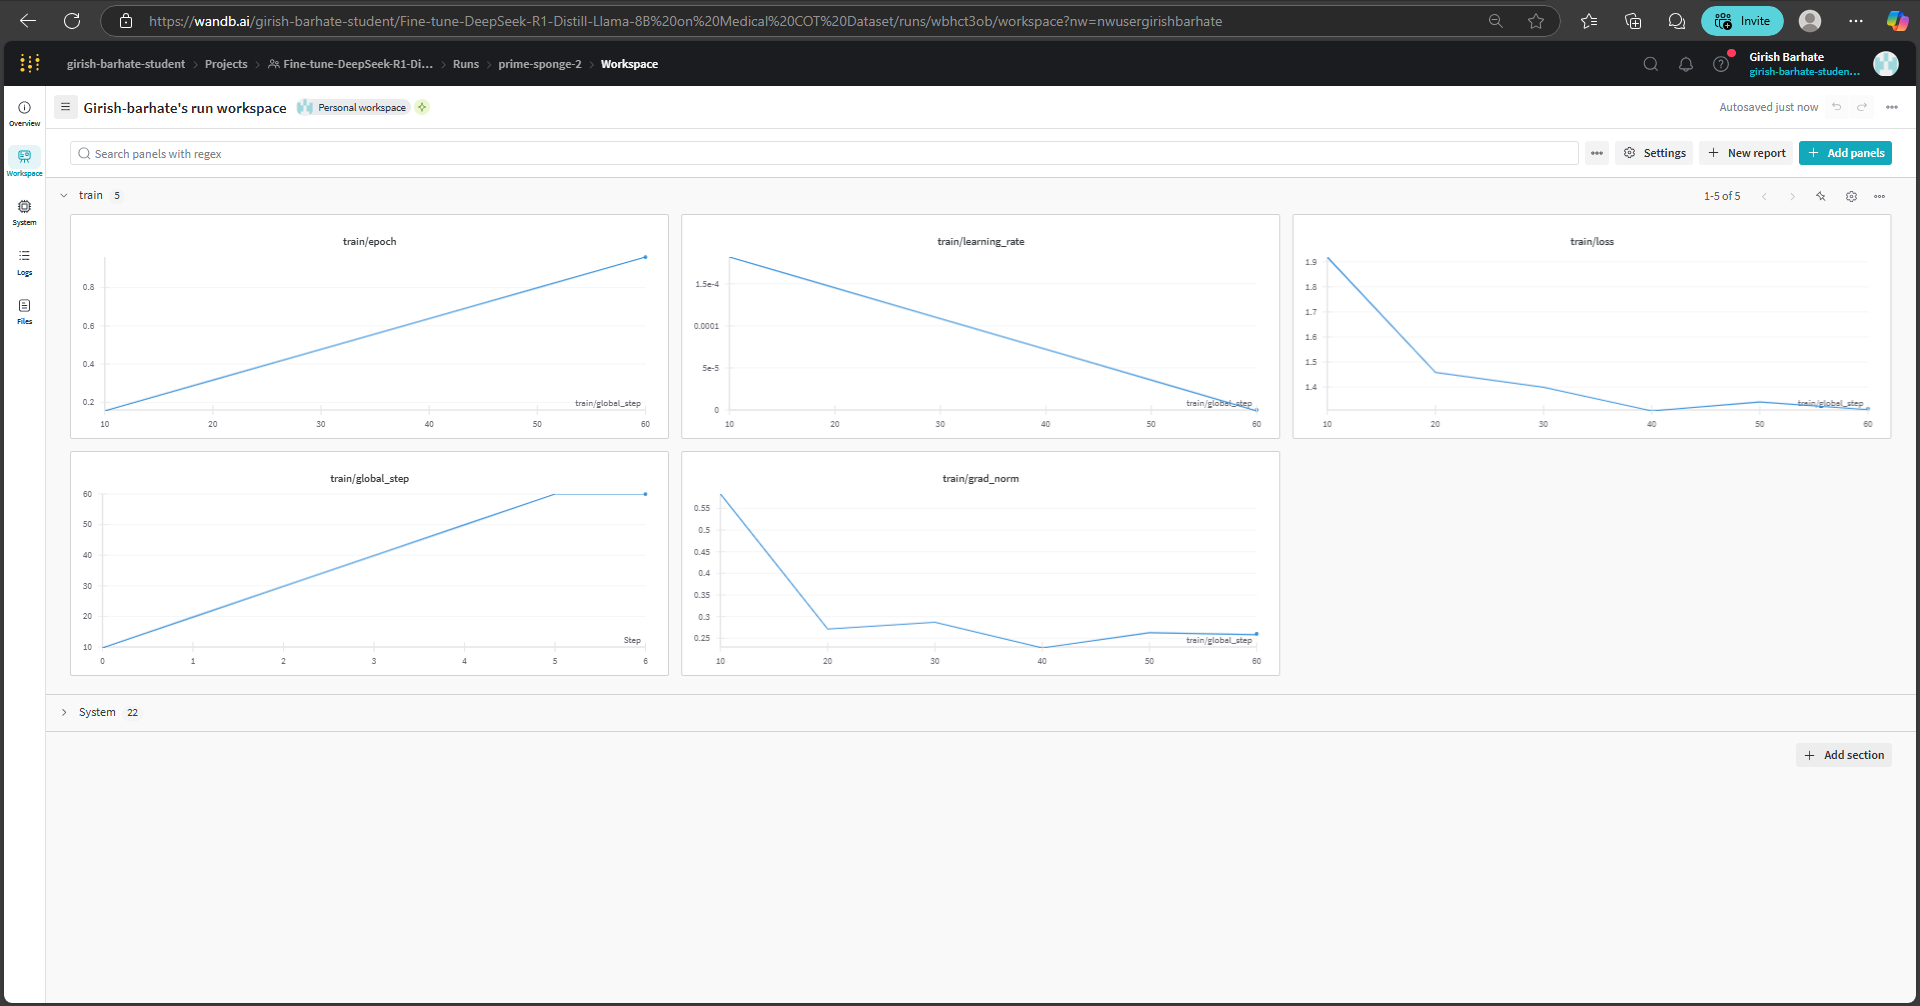

# 7. Model inference after fine-tuning

In [14]:
question = "A 61-year-old woman with a long history of involuntary urine loss during activities like coughing or sneezing but no leakage at night undergoes a gynecological exam and Q-tip test. Based on these findings, what would cystometry most likely reveal about her residual volume and detrusor contractions?"


FastLanguageModel.for_inference(model)  # Unsloth has 2x faster inference!
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")

outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=1200,
    use_cache=True,
)
response = tokenizer.batch_decode(outputs)
print(response[0].split("### Response:")[1])



<think>
Okay, so let's think about this. We have a 61-year-old woman who's been dealing with involuntary urine loss during things like coughing or sneezing, but she's not leaking at night. That suggests she might have some kind of problem with her pelvic floor muscles or maybe her bladder.

Now, she's got a gynecological exam and a Q-tip test. Let's break that down. The Q-tip test is usually used to check for urethral obstruction. If it's positive, that means there's something blocking the urethra, like a urethral stricture or something else.

Given that she's had a positive Q-tip test, it's likely there's a urethral obstruction. That would mean her urethra is narrow, maybe due to a stricture or some kind of narrowing. So, her bladder can't empty properly during activities like coughing because the urethral obstruction is making it hard.

Now, let's think about what happens when her bladder can't empty. If there's a urethral obstruction, the bladder is forced to hold more urine, incre

This is much better and more accurate. The chain of thought was direct, and the answer was straightforward and in one paragraph. The fine-tuning was successful.

# 8. Saving the model locally

In [15]:
new_model_local = "DeepSeek-R1-Medical-COT"
model.save_pretrained(new_model_local)
tokenizer.save_pretrained(new_model_local)

model.save_pretrained_merged(new_model_local, tokenizer, save_method = "merged_16bit",)

Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which might take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 6.0G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 4.0 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


 34%|███▍      | 11/32 [00:01<00:02,  8.47it/s]
We will save to Disk and not RAM now.
100%|██████████| 32/32 [01:10<00:00,  2.21s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving DeepSeek-R1-Medical-COT/pytorch_model-00001-of-00004.bin...
Unsloth: Saving DeepSeek-R1-Medical-COT/pytorch_model-00002-of-00004.bin...
Unsloth: Saving DeepSeek-R1-Medical-COT/pytorch_model-00003-of-00004.bin...
Unsloth: Saving DeepSeek-R1-Medical-COT/pytorch_model-00004-of-00004.bin...
Done.


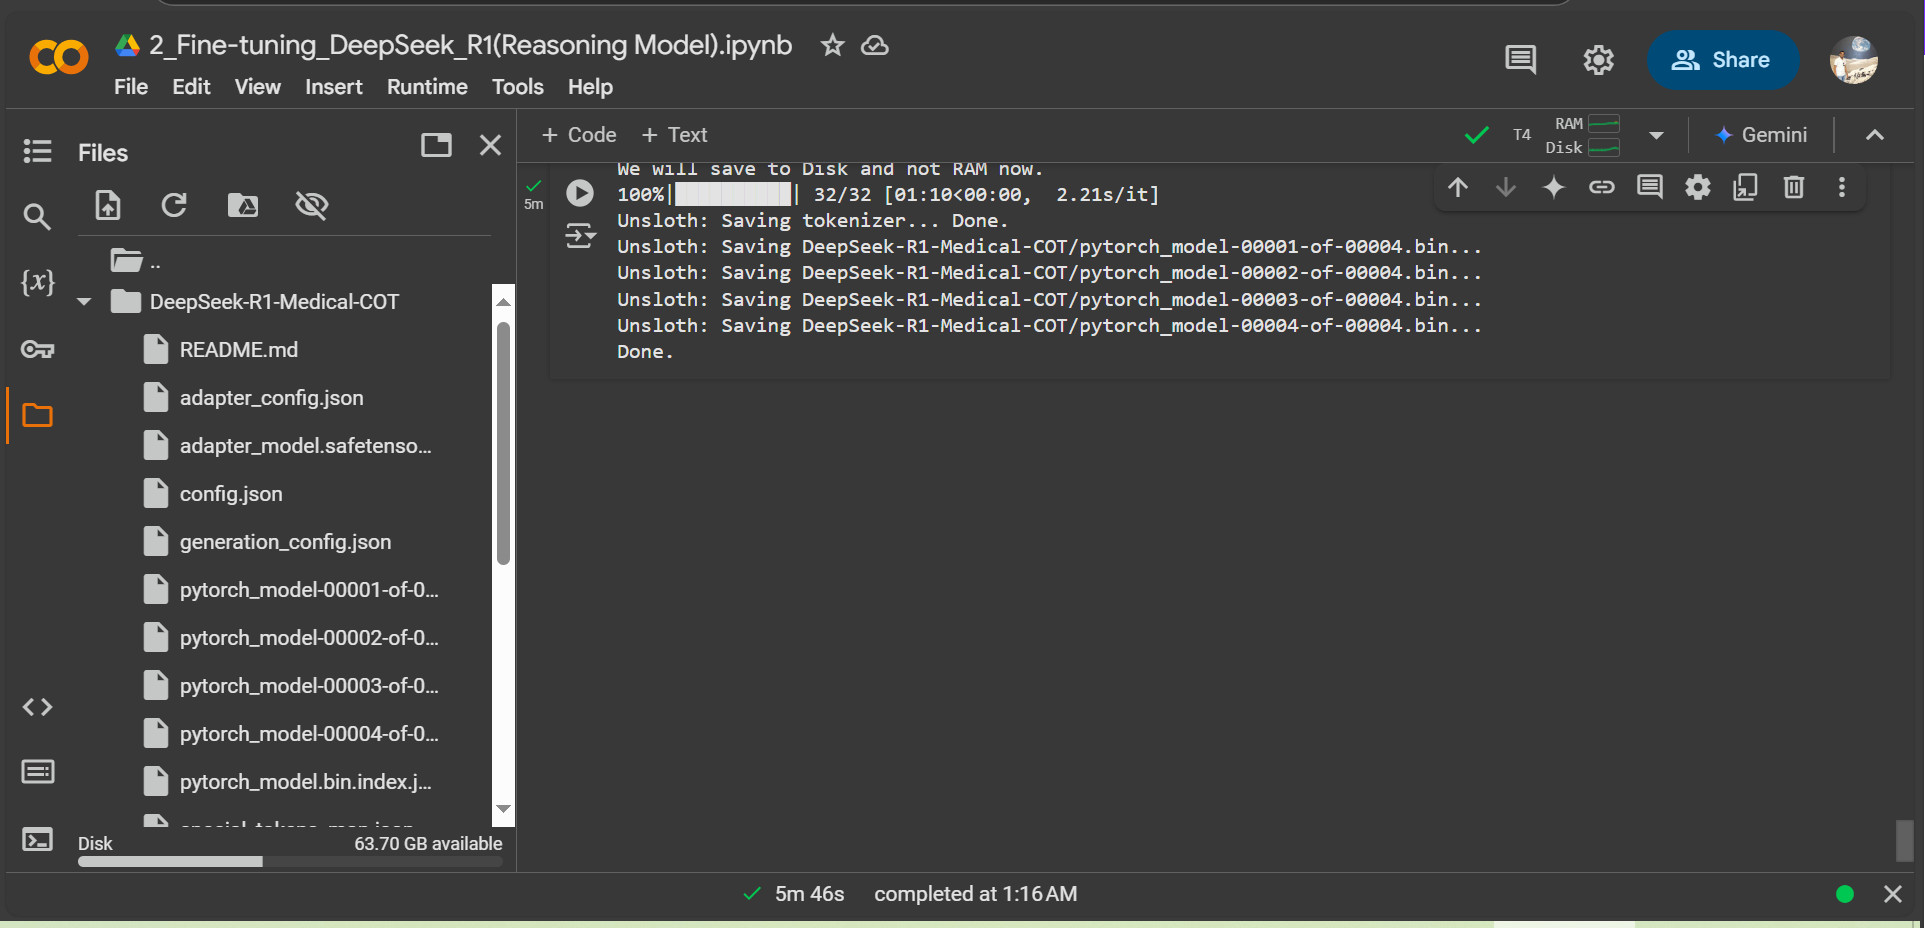